# Aufgabe-D-Schilder

## Allgemeines

Eine allgemeine Beschreibung der Laboraufgaben inklusive des Vorgehens, den Bewertungsrichtlinien und der Abgabe finden Sie  <a href="ML-allgemein.ipynb">hier</a>

## Bearbeiter
**TINF19-IT2**  
Patrick Küsters (9815596)  
Nick Kramer (3122448)  
**TINF19-IT1**  
Sören Holzenkamp (8528927)

## VM zum Trainieren großer Modelle

- Nutzung des Clusters der DHBW
    - wichtige Links
    - VPN-Endpunkt: drogon.dhbw-mannheim.de
    - Anmeldeseite Cluster: https://cloud.4c.dhbw-mannheim.de/
1. Ping external IP (Floating IP)
    1. Not working? --> New Floating IP
    2. Working --> ssh ubuntu@141.72.191.72 -i privatekey.txt

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/D_schilder herunter
    * Die Daten sind geschützt. 
    * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein. 
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen ml_2021 anmelden. 
    



## Readme der Daten

This archive contains the following structure:

There is one directory for each of the 43 classes (0000 - 00043).
Each directory contains the corresponding training images and one 
text file with annotations, eg. GT-00000.csv. 


**********************************************
Image format and naming  
**********************************************
The images are PPM images (RGB color). Files are numbered in two parts:

   XXXXX_YYYYY.ppm

The first part, XXXXX, represents the track number. All images of one class 
with identical track numbers originate from one single physical traffic sign.
The second part, YYYYY, is a running number within the track. The temporal order
of the images is preserved.


**********************************************
Annotation format
**********************************************

The annotations are stored in CSV format (field separator
is ";" (semicolon) ). The annotations contain meta information 
about the image and the class id.


In detail, the annotations provide the following fields:

Filename        - Image file the following information applies to
Width, Height   - Dimensions of the image
Roi.x1,Roi.y1,
Roi.x2,Roi.y2   - Location of the sign within the image
		  (Images contain a border around the actual sign
                  of 10 percent of the sign size, at least 5 pixel)
ClassId         - The class of the traffic sign


## Aufgabe

* die Daten 
    * enthalten mehr als 50000 Bilder von Verkehrsschilder auf deutschen Straßen
    * pro Klasse der Daten gibt es ein Verzeichnis
    * in jeder Klasse gibt eine CSV-Datei mit Annotationen der Bilder
        * Die Namen lauten GT-<ClassID>.csv
* die Bilder 
    * enthalten genau ein Verkehrszeichen, mit ca. 10% Rand um das Verkehrszeichen
    * sind im PPM Format gespeichert
    * die Größen der Bilder variieren von 15x15 Pixel bis zu 250x250 Pixel
        * die Bilder müssen aber nicht quadratisch sein
    * In den Annotationen ist auch die Bounding Box hinterlegt
* die Annotations-Datei hat den folgenden Werte
    * Dateiname, Width, Height, BB.x1, BB.y1, BB.x2, BB.y2, ClassId
        * BB steht für BoundingBox

Erstellen Sie ein tiefes neuronales Netz, dass Schilder in Bildern erkennt und die Position des erkannten Schilds als Bounding Box ausgibt! Die Lösung soll auch mehrere Schilder in einem Bild erkennen können! 


# Lösung

Implementierung und Dokumentation

## Imports
Lokal entwickelte Skripte und Module

In [1]:
import sys
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from reader import Reader
from display_data import ImageDisplayer

Externe Bibliotheken

In [2]:
import cv2
import pandas as pd

Funktion "drawImage" --> BB und Image wird dargestellt, mapping über Namen<br>
Einlesen von Bildern mit zugehörigen Namen

## Einlesen der Daten
Der Datensatz besteht aus 43 Ordnern, welche je eine Klasse abbilden.  
- Beispiel: In Ordner 0 liegen ausschließlich Bilder von Tempo 20 Schildern ab  

### Reader
Reader() stellt eine selbst entwickelte Klasse dar. <a href="./src/reader.py">Sie ist hier zu finden</a>.<br>
Diese iteriert durch alle Ordner und liest die Annotation-Files ein. Diese Informationen werden in einem pandas DataFrame gespeichert.  

In [4]:
reader = Reader()
df = reader.read_data(folders=43, pre_path=r"./data/")
df

,Filename,Folder,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000_00000.ppm,./data/0/,29,30,5,6,24,25,0
1,00000_00001.ppm,./data/0/,30,30,5,5,25,25,0
2,00000_00002.ppm,./data/0/,30,30,5,5,25,25,0
3,00000_00003.ppm,./data/0/,31,31,5,5,26,26,0
4,00000_00004.ppm,./data/0/,30,32,5,6,25,26,0
...,...,...,...,...,...,...,...,...,...
39204,00007_00025.ppm,./data/42/,52,56,5,6,47,51,42
39205,00007_00026.ppm,./data/42/,56,58,5,5,51,53,42
39206,00007_00027.ppm,./data/42/,58,62,5,6,53,57,42
39207,00007_00028.ppm,./data/42/,63,69,5,7,58,63,42


### Beschreibung der Daten
Der Datensatz besteht aus 39209 Einträgen, welcher sich in 43 Klassen unterteilt.  
Jeder Eintrag stellt ein Bild dar, welches eine gewissen Breite und Höhe besitzt. **Die Bilder besitzen also nicht die gleiche Größe.**  
Zudem ist die "Bounding Box" durch die 4 Spalten beginnend mit Roi abgebildet. (X1, Y1) spannt mit (X2, Y2) ein Rechteck auf, in welchem sich das Verkehrszeichen befinden soll.

Zusätzlich wird der Pfad zu der einzelnen Bilder gespeichert. Der Grund hierfür ist die Nicht-Eindeutigkeit der Dateinamen über den eigenen Ordner hinaus.  
Dies geht auch aus dem Readme der Daten hervor (ein Dateiname besteht aus Track und Tracknummer).  

In [19]:
lookup_filename = "00000_00000.ppm"
print("Vorkommnisse von " + lookup_filename + ":")
print(len(df.index[df["Filename"] == lookup_filename]))

print()

lookup_folder_with_filename = r"./data/0/00000_00000.ppm"
print("Vorkommnisse von " + lookup_folder_with_filename + ":")
print(len(df.index[df["Folder"] + df["Filename"] == lookup_folder_with_filename]))

Vorkommnisse von 00000_00000.ppm:
43

Vorkommnisse von ./data/0/00000_00000.ppm:
1


In [21]:
ImageDisplayer(df, 100, 105)

## Bildklassifizierung
### Vorbereitung

In [65]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from PIL import Image
import IPython.display as display
#from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

In [20]:
data = []
labels = []
bboxes = []
imagePaths = []

Um ein Gefühl für die Daten zu bekommen, wird eine Collage erstellt, die jedes 500. Bild darstellt.
Dabei ist auffällig, dass die Qualität der Bilder stark unterschiedlich ist.  
Einige Bilder sind extrem dunkel, andere wiederum sehr hell.  
Durch das Skalieren der Bilder unterscheidet sich die Auflösung stark.

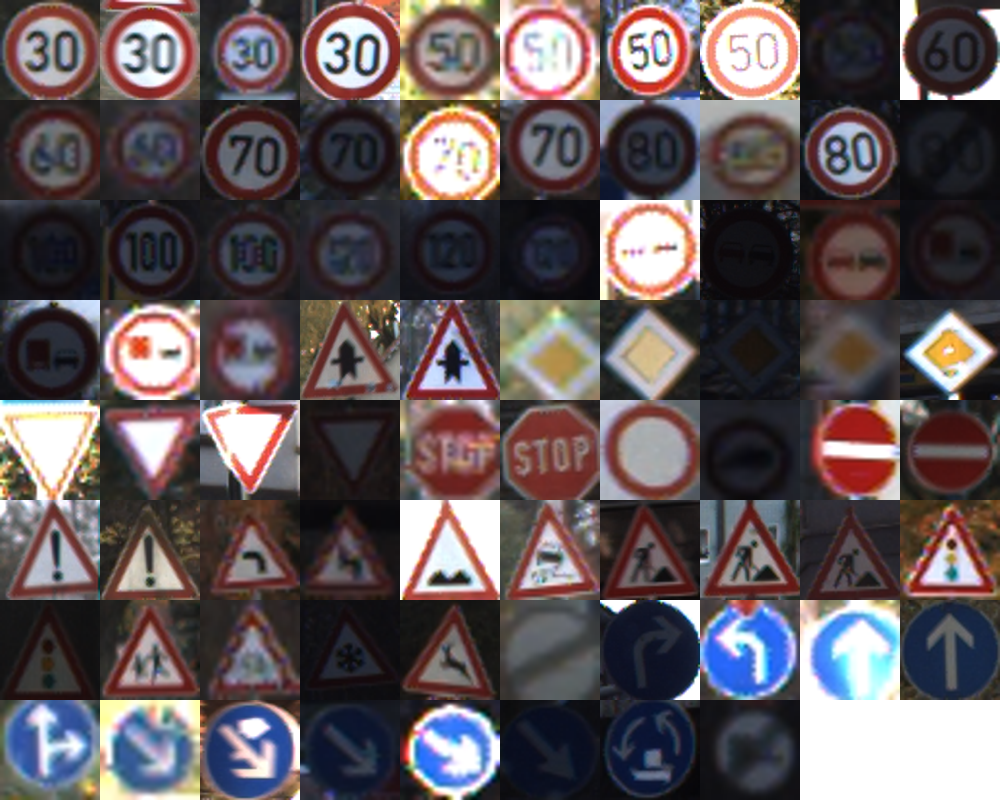

In [70]:
def create_collage(collage_savepath):
    collage = Image.new("RGBA", (1000, 800))
    x = 0
    y = 0
    for index, row in df.iterrows():
        image = load_img(row["Folder"]+row["Filename"])
        image = image.crop((row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"]))
        image = image.resize((100, 100))
        if(index > 0 and index%500 == 0):
            #print(index)
            collage.paste(image, (x,y))
            x+=100
            if(x > 900):
                x=0
                y+=100
    collage.save(collage_savepath)
    
create_collage(r"./images/collage_cropped_images.png")
display.Image(filename=r"./images/collage_cropped_images.png")

### CNN / Klassifizierung